In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

inspector = inspect(engine)

# Get table names
# tableNames = inspector.get_table_names()
# print(tableNames)

# Get Columns
# columns = inspector.get_columns('station')

# for column in columns:
#     print(column['name'], column['type'])

# measurement
    # id INTEGER
    # station TEXT
    # date TEXT
    # prcp FLOAT
    # tobs FLOAT
    
# station
    # id INTEGER
    # station TEXT
    # name TEXT
    # latitude FLOAT
    # longitude FLOAT
    # elevation FLOAT

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Don't touch this snippet
    # session.query(measurement, station).filter(station.station == measurement.station).all()

############################################    
conn = engine.connect()
max_date = pd.read_sql("Select Max(date) from measurement", conn)

# Calculate the date 1 year ago from the last data point in the database
one_yr_ago = dt.date(2017,8,23) - dt.timedelta(days = 365)


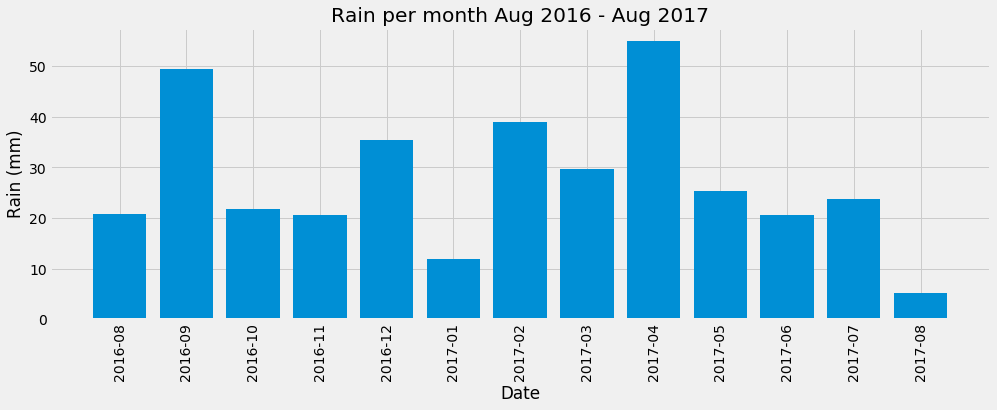

In [71]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(f"Select Date, prcp from measurement where date >= '{one_yr_ago}'", conn)
precip_df = precip_df.dropna()
precip_df.set_index(["date"])

# Sort the dataframe by date
precip_df.sort_values(["date"], ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
# Note: I took the 7 left characters (YYYY-MM) so that I could aggregate
# the precipitation data by year and month.
precip_df["year_mo"] = precip_df["date"].str[:7]

# Create Aggregate by year and month so summary plot works
agg_df = precip_df.groupby(["year_mo"])
plot_df = pd.DataFrame({"Precipitation" : agg_df["prcp"].sum()})
plot_df.reset_index(level = ["year_mo"], inplace = True)

# Set the x axis
x_axis = np.arange(len(plot_df))
tick_locations = [value+0.4 for value in x_axis]

# Plot the Data
plt.figure(figsize=(15,5))
plt.bar(plot_df["year_mo"], plot_df["Precipitation"], align="edge")
plt.xticks(tick_locations, plot_df["year_mo"], rotation="vertical")

# Set labels
plt.title("Rain per month Aug 2016 - Aug 2017")
plt.xlabel("Date")
plt.ylabel("Rain (mm)")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_prcp_df = pd.read_sql(f"Select prcp from measurement where date", conn)
all_prcp_df.dropna(how = "any", inplace = True)

mean_prcp = np.mean(all_prcp_df["prcp"])
median_prcp = np.median(all_prcp_df["prcp"])
var_prcp = np.var(all_prcp_df["prcp"])
std_dev_prcp = np.std(all_prcp_df["prcp"])
sem_prcp = st.sem(all_prcp_df["prcp"])

print(f"Rainfall mean: {mean_prcp}")
print(f"Rainfall median: {median_prcp}")
print(f"Rainfall variance: {var_prcp}")
print(f"Rainfall standard deviation: {std_dev_prcp}")
print(f"Rainfall standard error: {sem_prcp}")

Rainfall mean: 0.16064353974479206
Rainfall median: 0.01
Rainfall variance: 0.21971042383927294
Rainfall standard deviation: 0.46873278511244865
Rainfall standard error: 0.00348387087954466


In [13]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station).count()
print(station_count)

9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.station).label("Station_Count")).group_by(measurement.station)\
                                                    .order_by(desc("Station_Count")).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# type(session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station)\
#                                                     .order_by(func.count(measurement.station).desc()))

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_st = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station)\
                                                    .order_by(func.count(measurement.station).desc()).limit(1).all()

# Hi/Low/Avg temps
session.query(measurement.station, func.max(measurement.tobs),func.min(measurement.tobs),func.avg(measurement.tobs))\
                                                    .filter(measurement.station == most_active_st[0][0])\
                                                    .group_by(measurement.station)\
                                                    .order_by(func.count(measurement.station).desc()).limit(1).all()

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

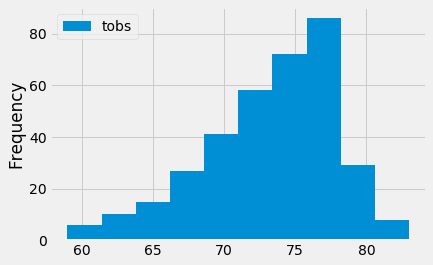

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs = session.query(measurement.tobs).filter(measurement.station == most_active_st[0][0]).filter(measurement.date >= one_yr_ago).all()
# print(most_obs)


list_temp = [t.tobs for t in most_obs]

df = pd.DataFrame(most_obs, columns=['tobs'])


df.plot.hist()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [85]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-10-15'
trip_end = '2016-10-20'

print(calc_temps(trip_start, trip_end))

[(70.0, 77.60526315789474, 81.0)]


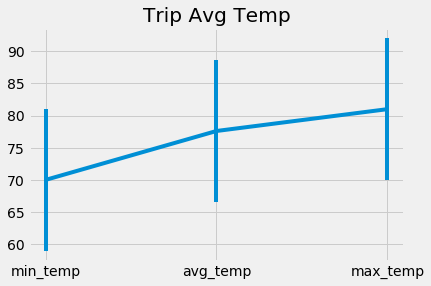

In [78]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temps = calc_temps('2016-10-15', '2016-10-20')
# print(trip_temps)


for i in trip_temps:
    y_values = i

x_values = ("min_temp", "avg_temp", "max_temp")

yerr = y_values[2] - y_values[0]

plt.errorbar(x_values, y_values, yerr)
# plt.errorbar(x_values, y_values, yerr)
# plt.plot(yerr)
plt.title("Trip Avg Temp")
plt.show()



In [93]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
total_rainfall = session.query(measurement.station, func.sum(measurement.prcp).label("Station_Count"))\
                                                            .filter(measurement.date >=trip_start)\
                                                            .filter(measurement.date <= trip_end)\
                                                            .group_by(measurement.station)\
                                                            .order_by(desc("Station_Count")).all()
print(total_rainfall)
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# ,station.latitude, station.longitude, station.elevation, 

session.query(measurement.station,\
              station.latitude, \
              station.longitude, \
              station.elevation,\
            func.sum(measurement.prcp))\
           .filter(measurement.date >=trip_start)\
           .filter(measurement.date <= trip_end)\
            .filter(measurement.station == station.station)\
           .group_by(measurement.station)\
           .order_by(desc(measurement.prcp)).all()

[('USC00516128', 2.19), ('USC00519281', 0.18), ('USC00513117', 0.14), ('USC00519523', 0.13999999999999999), ('USC00514830', 0.060000000000000005), ('USC00519397', 0.01), ('USC00517948', None)]


[('USC00516128', 21.3331, -157.8025, 152.4, 2.19),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 0.18),
 ('USC00514830', 21.5213, -157.8374, 7.0, 0.060000000000000005),
 ('USC00519523', 21.33556, -157.71139, 19.5, 0.13999999999999999),
 ('USC00519397', 21.2716, -157.8168, 3.0, 0.01),
 ('USC00513117', 21.4234, -157.8015, 14.6, 0.14),
 ('USC00517948', 21.3934, -157.9751, 11.9, None)]

In [94]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [98]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip
# ####################
# see trip_start and trip_end above
# ####################

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
trip_dates = ['10-15','10-16 ','10-17','10-18','10-19','10-20']

# Loop through the list of %m-%d strings and calculate the normals for each date

for date in trip_dates:
    trip_norms = daily_normals(date)
    
print(trip_norms)

[(67.0, 74.79629629629629, 82.0)]


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`


[(53.0, 73.09795396419437, 87.0)]